In [ ]:
%pip install git+https://github.com/kmayerb/tcrdist3.git@0.2.2
from tcrdist.repertoire import TCRrep
import pwseqdist as pw
from tcrdist.rep_funcs import _pws, _pw
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Loading in data and selecting relevant columns

In [7]:
df = pd.read_csv('vdjdb_full.txt', delimiter = '\t')
# Based on the guidance, let's start preprocessing by filtering the dataset based on quality scores.

relevant_columns = [
    'cdr3.alpha', 'v.alpha', 'j.alpha', 'cdr3.beta', 'v.beta', 'd.beta', 'j.beta',
    'species', 'mhc.a', 'mhc.b', 'antigen.gene','antigen.epitope', 'vdjdb.score'
]

# For the purpose of this example, we won't filter out lower-quality scores to avoid data imbalance,
# but in practice, you may want to consider this based on the dataset's size and distribution.
filtered_data = df[relevant_columns]
# Displaying the first few rows of the filtered dataset to verify the selection
filtered_data


<ipython-input-7-21255f8fbd4a>:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('vdjdb_full.txt', delimiter = '\t')


,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,species,mhc.a,mhc.b,antigen.gene,antigen.epitope,vdjdb.score
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
1,NaN,NaN,NaN,CASSFEAGQGFFSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
2,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
3,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
4,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,NaN,TRBJ2-1*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62172,CMDEGGSNYKLTF,TRAV26-1*01,TRAJ53*01,CASSVRSTDTQYF,TRBV7-2*01,NaN,TRBJ2-3*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,PQPELPYPQPQL,0
62173,CSLYNNNDMRF,TRAV26-1*01,TRAJ43*01,CASSLRYTDTQYF,TRBV7-2*01,NaN,TRBJ2-3*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,PQPELPYPQPQL,0
62174,CALSTDSWGKLQF,TRAV6*01,TRAJ24*01,CASSPGQGGDNEQFF,TRBV7-3*01,NaN,TRBJ2-1*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,PQQPFPQPEQPFP,0
62175,CAPQGATNKLIF,TRAV12-2*01,TRAJ32*01,CASSLGAGGQETQYF,TRBV5-1*01,NaN,TRBJ2-5*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,PQQPFPQPEQPFP,2


# examining missing and unique values

In [8]:
# Checking for missing values in crucial columns
missing_values = filtered_data.isnull().sum()

# Examining the number of unique values in categorical columns for potential encoding strategies
unique_values = filtered_data.nunique()

# Preparing the report
report = {
    "Missing Values": missing_values,
    "Unique Values": unique_values
}

report


{'Missing Values': cdr3.alpha         24128
 v.alpha            24204
 j.alpha            25157
 cdr3.beta           7455
 v.beta              7446
 d.beta             41741
 j.beta              7541
 species                0
 mhc.a                  0
 mhc.b                  0
 antigen.gene          31
 antigen.epitope        0
 vdjdb.score            0
 dtype: int64,
 'Unique Values': cdr3.alpha         27097
 v.alpha              158
 j.alpha               65
 cdr3.beta          41899
 v.beta                91
 d.beta                12
 j.beta                25
 species                3
 mhc.a                119
 mhc.b                 45
 antigen.gene         268
 antigen.epitope     1169
 vdjdb.score            4
 dtype: int64}

In [9]:
# Removing rows with missing cdr3 sequences
df_cleaned = filtered_data.dropna(subset=['cdr3.alpha', 'cdr3.beta'])
df_cleaned.reset_index(drop=True, inplace=True)
df_cleaned
missing_values_d = df_cleaned['d.beta'].isnull().sum()
missing_values_d

13811

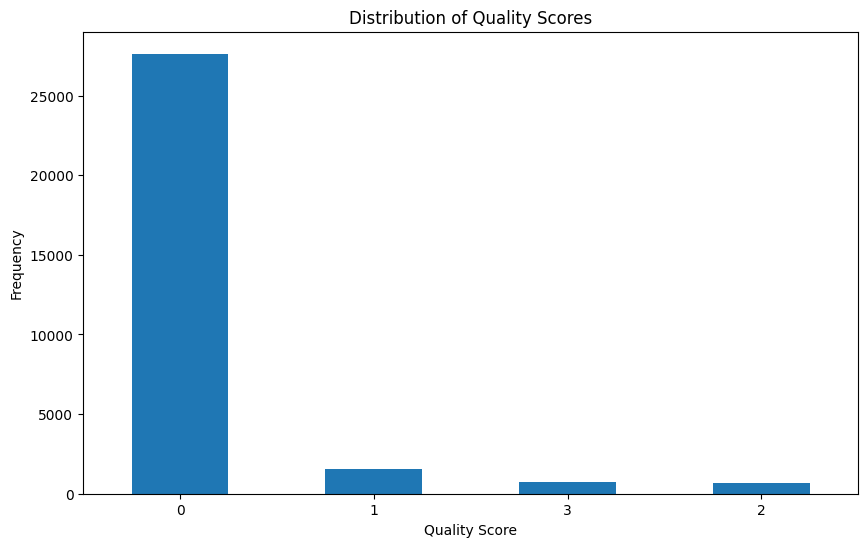

0    27629
1     1580
3      717
2      668
Name: vdjdb.score, dtype: int64

In [10]:
import matplotlib.pyplot as plt

# Assuming 'df_cleaned' is your cleaned DataFrame after removing rows with missing cdr3 sequences
quality_scores = df_cleaned['vdjdb.score'].value_counts()

# Plotting the distribution of quality scores
plt.figure(figsize=(10, 6))
quality_scores.plot(kind='bar')
plt.title('Distribution of Quality Scores')
plt.xlabel('Quality Score')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keeping the x-axis labels horizontal for readability
plt.show()
quality_scores

whilst 0 is the most frequent class, the data with a score of 0 can be seen to be unreliable, so it is filtered out.

In [11]:
# Filtering out data points with a quality score of 0
df_filtered = df_cleaned[df_cleaned['vdjdb.score'] > 0]
# Removing the 'd.beta' column from the filtered DataFrame
df_filtered = df_filtered.drop(columns=['d.beta'])

df_filtered[:]



,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,j.beta,species,mhc.a,mhc.b,antigen.gene,antigen.epitope,vdjdb.score
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
1,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
2,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
3,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
4,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEQGGL,2
...,...,...,...,...,...,...,...,...,...,...,...,...
30549,CIALNARLMF,TRAV26-1*01,TRAJ31*01,CASSLRATDTQYF,TRBV7-2*01,TRBJ2-3*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,PQPELPYPQPQL,2
30550,CAMREGRYSSASKIIF,TRAV14/DV4*01,TRAJ3*01,CATSRAGGGGEKLFF,TRBV15*01,TRBJ1-4*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,FPQPEQPFPWQP,2
30551,CLVGDGDGGATNKLIF,TRAV4*01,TRAJ32*01,CASSQGSGGNEQFF,TRBV4-3*01,TRBJ2-1*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,FPQPEQPFPWQP,2
30553,CAASVLYGSSNTGKLIF,TRAV29/DV5*01,TRAJ37*01,CASSIVGSGGYNEQFF,TRBV19*01,TRBJ2-1*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,QLQPFPQPELPY,2


In [12]:
df_slim = df_filtered.iloc[:,[0,1,2,3,4,5,6,9,10]]

df_slim.rename(columns={'cdr3.alpha': 'cdr3_a_aa', 'cdr3.beta': 'cdr3_b_aa', 'v.alpha':'v_a_gene','j.alpha': 'j_a_gene','v.beta': 'v_b_gene','j.beta': 'j_b_gene',}, inplace=True)

df_slim.to_csv('df_slim.csv', index = False)
df_slim

<ipython-input-12-b62a5c1ae2fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slim.rename(columns={'cdr3.alpha': 'cdr3_a_aa', 'cdr3.beta': 'cdr3_b_aa', 'v.alpha':'v_a_gene','j.alpha': 'j_a_gene','v.beta': 'v_b_gene','j.beta': 'j_b_gene',}, inplace=True)


,cdr3_a_aa,v_a_gene,j_a_gene,cdr3_b_aa,v_b_gene,j_b_gene,species,antigen.gene,antigen.epitope
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef,FLKEKGGL
1,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef,FLKEKGGL
2,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef,FLKEKGGL
3,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,HomoSapiens,Nef,FLKEKGGL
4,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef,FLKEQGGL
...,...,...,...,...,...,...,...,...,...
30549,CIALNARLMF,TRAV26-1*01,TRAJ31*01,CASSLRATDTQYF,TRBV7-2*01,TRBJ2-3*01,HomoSapiens,Gluten,PQPELPYPQPQL
30550,CAMREGRYSSASKIIF,TRAV14/DV4*01,TRAJ3*01,CATSRAGGGGEKLFF,TRBV15*01,TRBJ1-4*01,HomoSapiens,Gluten,FPQPEQPFPWQP
30551,CLVGDGDGGATNKLIF,TRAV4*01,TRAJ32*01,CASSQGSGGNEQFF,TRBV4-3*01,TRBJ2-1*01,HomoSapiens,Gluten,FPQPEQPFPWQP
30553,CAASVLYGSSNTGKLIF,TRAV29/DV5*01,TRAJ37*01,CASSIVGSGGYNEQFF,TRBV19*01,TRBJ2-1*01,HomoSapiens,Gluten,QLQPFPQPELPY


In [43]:
# Filtering rows where species is "Mus" (assuming "Mus" represents mouse)
# It seems from the initial peek that the dataset might not contain "Mus" directly, so let's filter for anything that's not "HomoSapiens"
# to potentially capture the mouse data if labeled differently (e.g., Mus musculus or simply Mus)

df_mouse = df_slim[df_slim['species'] != 'HomoSapiens']

# Creating the datasets
# 1. Mouse species data with alpha chains
mouse_alpha = df_mouse[['cdr3_a_aa', 'v_a_gene', 'j_a_gene', 'species','antigen.gene',	'antigen.epitope']]

# 2. Mouse species data with beta chains
mouse_beta = df_mouse[['cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'species', 'antigen.gene',	'antigen.epitope']]

# 3. Mouse species data with both chains
mouse_both = df_mouse
# Resetting index for each dataset before saving
mouse_alpha.reset_index(drop=True, inplace=True)
mouse_beta.reset_index(drop=True, inplace=True)
mouse_both.reset_index(drop=True, inplace=True)


# Let's check the number of rows in each dataset to ensure we have mouse data
mouse_alpha.shape[0], mouse_beta.shape[0], mouse_both.shape[0]

# Assuming your DataFrame is named mouse_beta_df and the epitope information is in a column named 'antigen.epitope'

# Count the occurrences of each epitope
epitope_counts = mouse_beta['antigen.epitope'].value_counts()

# Filter for epitopes with more than 4 entries
epitopes_with_more_than_four_entries = epitope_counts[epitope_counts > 4].index

# Filter the original DataFrame
filtered_mouse_beta_df = mouse_beta[mouse_beta['antigen.epitope'].isin(epitopes_with_more_than_four_entries)]
filtered_mouse_beta_df['antigen.epitope'].value_counts()


SSYRRPVGI        261
ASNENMETM        136
SSLENFRAYV       130
SSPPMFRV         106
HGIRNASFI        102
TVYGFCLL          63
LSLRNPILV         62
SIINFEKL           6
RVSYYGPKTSPVQ      5
Name: antigen.epitope, dtype: int64

In [ ]:
# <chains> - tcrdist3 accepts ['alpha', 'beta'] or ['alpha'] or ['beta']
chains = ['alpha', 'beta']
# <cdr3> We can choose either 'cdr3' or 'all'. Choosing 'all' will
# compute distances using CDR1,CDR2, and CDR2.5 as well as CDR3
cdrs = 'all'
organism = 'mouse'
db_file = 'alphabeta_gammadelta_db.tsv'

#beta only

In [65]:
tr = TCRrep(cell_df=mouse_both,
            organism='mouse',
            chains=['alpha', 'beta'],
            db_file='alphabeta_gammadelta_db.tsv',
            deduplicate=True)

/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.cell_df['count'] = 1
/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:190: UserWarning: Not all cells/sequences could be grouped into clones.26 of 925 were not captured. This occurs when any of the values in the index columns are null or missing for a 

In [66]:
X_beta = pd.DataFrame(tr.pw_alpha + tr.pw_beta)
Y_beta = tr.clone_df['antigen.epitope'].copy() # target labels
X_beta.to_csv('X_beta.csv',index = False)
Y_beta.to_csv('Y_beta.csv',index = False)

#clustering

<ipython-input-18-54041644e131>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_new = linkage(X_beta, 'ward')


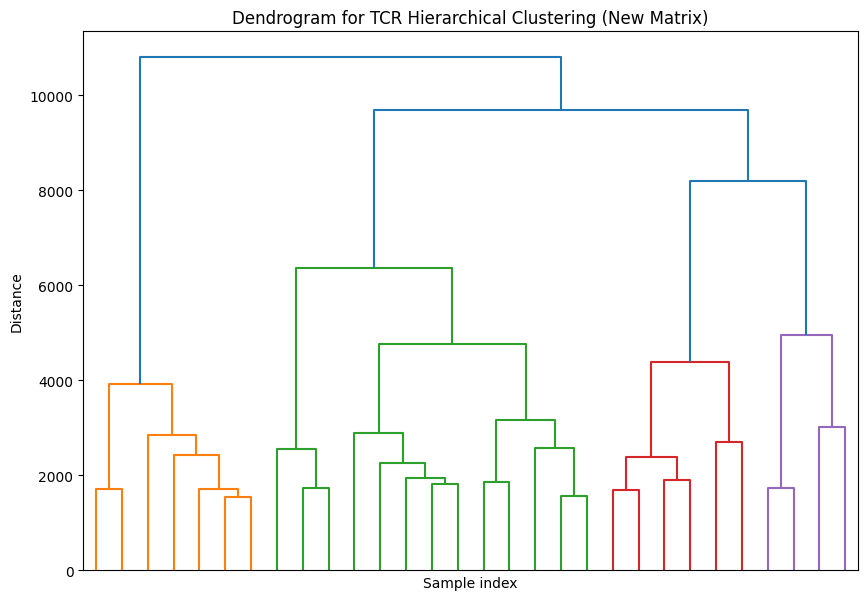

In [18]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
# Perform hierarchical clustering on the corrected matrix
Z_new = linkage(X_beta, 'ward')

# Plot the dendrogram to help decide on the number of clusters, focusing on the last 30 merged clusters to keep the plot readable
plt.figure(figsize=(10, 7))
dendrogram(Z_new, no_labels=True, truncate_mode='lastp', p=30)
plt.title("Dendrogram for TCR Hierarchical Clustering (New Matrix)")
plt.xlabel("Sample index")
plt.ylabel("Distance")

plt.show()


In [19]:
from scipy.cluster.hierarchy import fcluster

# To assist in selecting the number of clusters, we'll determine the distances at which merges occur in the dendrogram
# We'll take a look at the largest distances where significant merges happen to suggest a cut-off

# Getting all the merge distances from the linkage matrix
merge_distances = Z_new[:, 2]

# Sorting merge distances in descending order
sorted_merge_distances = np.sort(merge_distances)[::-1]

# We will consider the top longest distances which might be a good threshold for cutting the dendrogram
# We'll select a few top merge distances to suggest as potential cut-offs
potential_cutoffs = sorted_merge_distances[:5]

# For each potential cut-off, calculate the corresponding number of clusters it would produce
clusters_at_cutoffs = [fcluster(Z_new, t, criterion='distance').max() for t in potential_cutoffs]

# Pairing each potential cut-off with its corresponding number of clusters
cutoffs_and_clusters = list(zip(potential_cutoffs, clusters_at_cutoffs))
cutoffs_and_clusters


[(10807.395402296626, 1),
 (9700.451120167958, 2),
 (8195.263856133115, 3),
 (6367.885350973057, 4),
 (4958.504249816563, 5)]

In [20]:
# The user has selected to proceed with 5 clusters. We will now use a cut-off distance that corresponds to 5 clusters
# to segment the dendrogram and assign cluster labels to each observation (TCR sequence).

# The cut-off distance for 5 clusters from the previous output
cutoff_distance_5_clusters = cutoffs_and_clusters[4][0]

# Assign cluster labels based on the selected cut-off distance
cluster_labels = fcluster(Z_new, cutoff_distance_5_clusters, criterion='distance')

# Let's check the distribution of the cluster sizes
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
cluster_distribution


{1: 150, 2: 34, 3: 170, 4: 134, 5: 134}

# evaluate clusters, use different clustering methods too. vsiualise

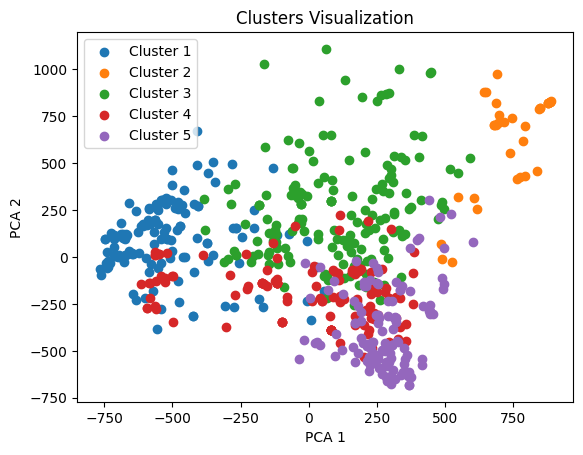

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_beta)

# Plot each cluster
for i, label in enumerate(unique):
    plt.scatter(X_pca[cluster_labels == label, 0], X_pca[cluster_labels == label, 1], label=f'Cluster {label}')

plt.title('Clusters Visualization')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()


#KNN

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder

Y_beta = Y_beta.squeeze()

# Label encoding for Y_beta
label_encoder = LabelEncoder()
Y_beta_encoded = label_encoder.fit_transform(Y_beta)

# KNN parameters
k_cv = 5
k_neighbours = 5

# Prepare for cross-validation
kfolds = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=1)
metrics_cv_df = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision'])

# Perform cross-validation
for train_index, test_index in kfolds.split(X_beta, Y_beta_encoded):
    # Split the data
    X_train, X_test = X_beta.iloc[train_index], X_beta.iloc[test_index]
    Y_train, Y_test = Y_beta_encoded[train_index], Y_beta_encoded[test_index]

    # Initialize and train the KNN model
    knn_model = KNeighborsClassifier(n_neighbors=k_neighbours)
    knn_model.fit(X_train, Y_train)

    # Predictions
    y_pred = knn_model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred, average='macro', zero_division=0)
    precision = precision_score(Y_test, y_pred, average='macro', zero_division=0)

    # Store metrics
    metrics_cv_df = metrics_cv_df.append({
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision
    }, ignore_index=True)

print(metrics_cv_df)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
<ipython-input-67-550c27574386>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_cv_df = metrics_cv_df.append({
<ipython-input-67-550c27574386>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_cv_df = metrics_cv_df.append({
<ipython-input-67-550c27574386>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_cv_df = metrics_cv_df.append({


   Accuracy    Recall  Precision
0  0.683544  0.320398   0.310342
1  0.740506  0.331405   0.289283
2  0.651899  0.328593   0.285143
3  0.670886  0.288980   0.299746
4  0.757962  0.343159   0.346313


<ipython-input-67-550c27574386>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_cv_df = metrics_cv_df.append({
<ipython-input-67-550c27574386>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_cv_df = metrics_cv_df.append({


In [68]:
from sklearn.metrics import classification_report

# Get unique labels from Y_test and y_pred combined
unique_labels = np.unique(np.concatenate([Y_test, y_pred]))

# Inverse transform the unique labels to get the original class names
original_class_names = label_encoder.inverse_transform(unique_labels)

# Generate the classification report only for the classes present
print(classification_report(Y_test, y_pred, labels=unique_labels, target_names=original_class_names))


                precision    recall  f1-score   support

ADGLAYFRSSFKGG       0.00      0.00      0.00         0
 ADLIAYLKQATKG       0.00      0.00      0.00         1
     ASNENMETM       0.76      0.90      0.83        21
      EQYKFYSV       0.00      0.00      0.00         0
  FEAQKAKANKAV       0.00      0.00      0.00         1
 FEAQKAKANKAVD       0.00      0.00      0.00         1
FEAQKAKANKAVDG       0.00      0.00      0.00         1
     FLSPFWFDI       0.00      0.00      0.00         1
     HGIRNASFI       0.88      0.83      0.86        18
     KAPANFATM       0.00      0.00      0.00         1
     KAPFNFATM       0.00      0.00      0.00         0
     LSLRNPILV       0.62      0.91      0.74        11
     MPAGRPWDL       0.00      0.00      0.00         0
     QLSPFPFDL       1.00      1.00      1.00         1
    RGPGRAFVTI       0.00      0.00      0.00         1
 RVSYYGPKTSPVQ       0.00      0.00      0.00         0
      SIINFEKL       1.00      1.00      1.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

# knn serves as a benchmark, achieving roughly 53% accuracy. It most accurately predicts those epitopes that have the most TCRs corresponding to them. It struggles on epitopes that only correspond to one TCR, as expected.